# 수집된 데이터에 대한 통계 분석
* 데이터 
> 2017년 12월 1일부터 2018년 1월 1일까지 32일간 [네이버](http://www.naver.com)와 [다음](http://www.daum.net)의 랭킹뉴스와 뉴스의 댓글을 크롤링함.

In [440]:
import os
import pandas as pd 
from glob import glob
import sys
import time, re, pickle, itertools
import urllib3, json
sys.path.append('~/Documents/GitHub/Private_Project/personal_project/')
import re
from operator import itemgetter
import html
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import chat_bot as cb
import Database_Handler as dh
from datetime import datetime
import seaborn as sns
import functools
%matplotlib inline

# 네이버 (Naver)

## 1. 뉴스에 대한 통계분석

In [239]:
file = './data/pre_data/for_statistics_Naver_from_mongodb.pickled'
dataDict_naver = pickle.load(open(file,'rb'))

In [240]:
df_naver = pd.DataFrame.from_dict(dataDict_naver, orient='index')
df_naver['date'] = pd.to_datetime(df_naver['date']).dt.date
df_naver.reset_index(inplace = True)
df_naver.rename(columns={'index':'id'}, inplace=True)
print (df_naver.shape)
df_naver.head()

(7681, 6)


id category        date press  number_of_comment  \
0  5a29c445588c132954d1973a       정치  2017-12-07  연합뉴스               1713   
1  5a29c445588c132954d1973b       정치  2017-12-07  한국일보               2551   
2  5a29c445588c132954d1973c       정치  2017-12-07   뉴시스                610   
3  5a29c445588c132954d1973d       정치  2017-12-07  연합뉴스                145   
4  5a29c445588c132954d1973e       정치  2017-12-07  동아일보               1074   

   number_of_crawled_comment  
0                       1474  
1                       2121  
2                        540  
3                        134  
4                        937

In [241]:
start = df_naver['date'].min()
end = df_naver['date'].max()
print ('수집된 날짜 : {} ~ {}, {}일간'.format(start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d'), (end-start).days+1))
count = len(df_naver['press'].unique())
print ('number of news in naver : {} '.format(df_naver.shape[0]))
print ('네이버 뉴스에 등록된 언론사의 수 : {}'.format(129))
print ('뉴스 기사가 한번이라도 네이버의 랭킹뉴스에 등록된 언론사의 수 : {}, 전체의 {:0.1f}%'.format(count, count/129*100))

수집된 날짜 : 2017-12-01 ~ 2018-01-01, 32일간
number of news in naver : 7681 
네이버 뉴스에 등록된 언론사의 수 : 129
뉴스 기사가 한번이라도 네이버의 랭킹뉴스에 등록된 언론사의 수 : 93, 전체의 72.1%


### NAVER 뉴스에 등록된 언론사
![사진](./naver_news.png )
총 : 129개사

In [161]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
def OS_Driver(os,browser):
    if os.lower() == 'windows':
        if browser.lower() == 'phantom':
            driver = webdriver.PhantomJS('C:/Users/pc/Documents/phantomjs-2.1.1-window/bin/phantomjs.exe')
        else:
            driver = webdriver.Chrome('C:/Users/pc/Documents/chromedriver.exe')
    elif os.lower() == 'mac':
        if browser.lower() == 'phantom':
            driver = webdriver.PhantomJS(
                '/Users/hyunyoun/Documents/GitHub/Private_Project/phantomjs-2.1.1/bin/phantomjs')
        else:
            driver = webdriver.Chrome('/Users/hyunyoun/Documents/GitHub/Private_Project/chromedriver')
    return driver
web = 'http://news.naver.com/'
driver = OS_Driver('mac', 'chrome')
driver.get(web)
driver.find_element_by_id('index.press.btn').click()
x = driver.find_element_by_id('index.press.area')
x2 = x.find_element_by_class_name('index_content')
x3 = x2.find_elements_by_css_selector('div')
pressdict = dict()
for idx in x3:
    cat = idx.find_elements_by_css_selector('h5')
    sub = idx.find_elements_by_css_selector('ul')
    y = list(zip(list(map(lambda x: re.sub('[\[\]]','',x.text), cat)), list(map(lambda x: x.text.split('\n'), sub))))
    for key, value in y:
        pressdict[key] = value
driver.quit()

In [330]:
enrolledPress = list()
for idx in pressdict:
    enrolledPress.append((idx.strip(), len(pressdict[idx])))
enrolledPress = pd.DataFrame(enrolledPress)
enrolledPress.rename(columns={0:'category',1:'count'},inplace = True)
enrolledPress.set_index('category', inplace = True)

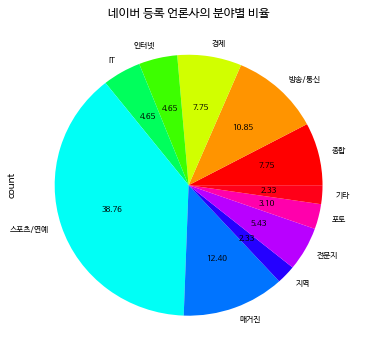

In [448]:
enrolledPress['count'].plot.pie(autopct='%.2f', colormap = plt.get_cmap('hsv'), fontsize=8, figsize=(6, 6),title='네이버 등록 언론사의 분야별 비율')

### 수집기간동안 네이버 랭킹뉴스에 한건이라도 나온 언론사

In [331]:
count_by_press = df_naver.groupby('press')['id'].count().sort_values(ascending=False)
pressIn_ranked = list()
cat_press_in_ranked = dict()
for idx in count_by_press.index:
    for key in pressdict:
        if idx in pressdict[key]:
            pressIn_ranked.append(key)
            cat_press_in_ranked[idx] = key
            break
pressIn_ranked = Counter(pressIn_ranked)
pressIn_ranked = pd.DataFrame.from_dict(pressIn_ranked,orient='index')
pressIn_ranked.rename(columns={0:'count_in_ranked'}, inplace = True)

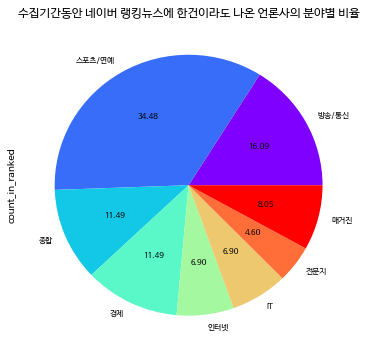

In [450]:
pressIn_ranked['count_in_ranked'].plot.pie(autopct='%.2f', fontsize=8,colormap = plt.get_cmap('rainbow'), figsize=(6, 6), title = '수집기간동안 네이버 랭킹뉴스에 한건이라도 나온 언론사의 분야별 비율')

In [367]:
total_and_ranked = pd.merge(enrolledPress, pressIn_ranked, left_index=True, right_index=True, how='outer')
total_and_ranked.fillna(0,inplace=True)
total_and_ranked['count_in_ranked'] = total_and_ranked['count_in_ranked'].astype(int)
total_and_ranked['percentage'] = total_and_ranked['count_in_ranked']/total_and_ranked['count'] * 100
total_and_ranked = total_and_ranked.sort_values(by='percentage', ascending=False)
total_and_ranked.T

IT     경제  방송/통신    인터넷     종합  스포츠/연예        전문지    매거진  \
count              6.0   10.0   14.0    6.0   10.0    50.0   7.000000  16.00   
count_in_ranked    6.0   10.0   14.0    6.0   10.0    30.0   4.000000   7.00   
percentage       100.0  100.0  100.0  100.0  100.0    60.0  57.142857  43.75   

                  기타   지역   포토  
count            3.0  3.0  4.0  
count_in_ranked  0.0  0.0  0.0  
percentage       0.0  0.0  0.0

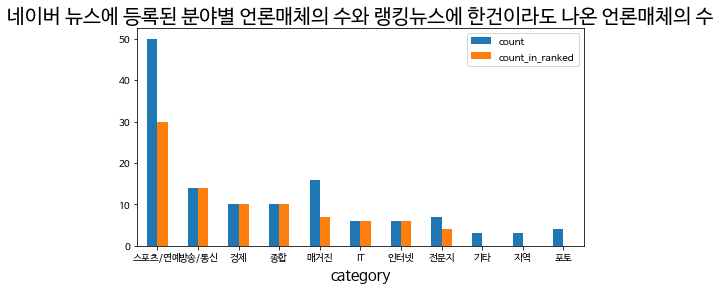

In [522]:
f1 = plt.figure(figsize=(8,4))
plt.title('네이버 뉴스에 등록된 분야별 언론매체의 수와 랭킹뉴스에 한건이라도 나온 언론매체의 수', color='black',fontsize=20)
total_and_ranked[['count','count_in_ranked']].sort_values(by='count_in_ranked', ascending=False).plot(kind='bar', ax=f1.gca())
plt.xticks(fontsize=10,rotation=0)
plt.yticks(fontsize=10)
plt.xlabel('category',fontsize=15)
plt.show()

### 일별 뉴스기사수

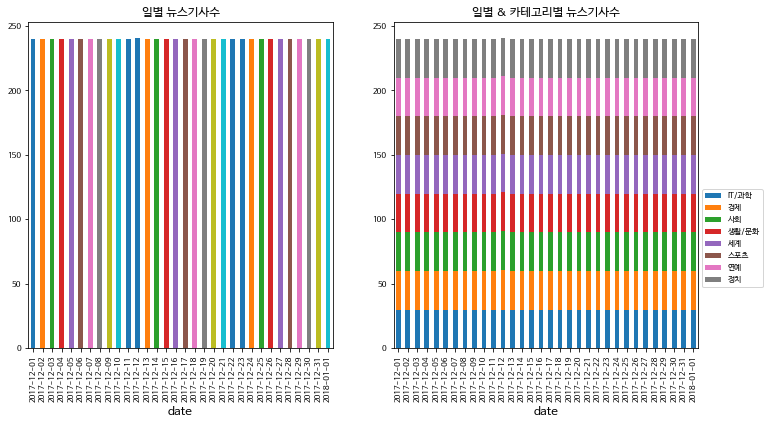

In [242]:
f1 = plt.figure(figsize=(12,6))
ax1 = f1.add_subplot(1, 2, 1)
plt.title('일별 뉴스기사수', color='black')
df_naver.groupby('date')['id'].count().plot(kind = 'bar',rot=90,ax=ax1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('date',fontsize=12)
ax2 = f1.add_subplot(1, 2, 2)
plt.title('일별 & 카테고리별 뉴스기사수', color='black')
df_naver.groupby(['date','category'])['id'].count().unstack().plot(kind='bar',stacked=True,ax=ax2)
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5),fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('date',fontsize=12)
plt.show()

* 2017년 12월 12일은 241개, 나머지는 240개
> * 총 7681개의 뉴스기사
* 8개의 카테고리별로 30개씩 하루에 240개, 2017년 12월 12일만 경제 카테고리에서 31개임

### 언론사별 뉴스기사수

In [243]:
count_by_press = df_naver.groupby('press')['id'].count().sort_values(ascending=False)

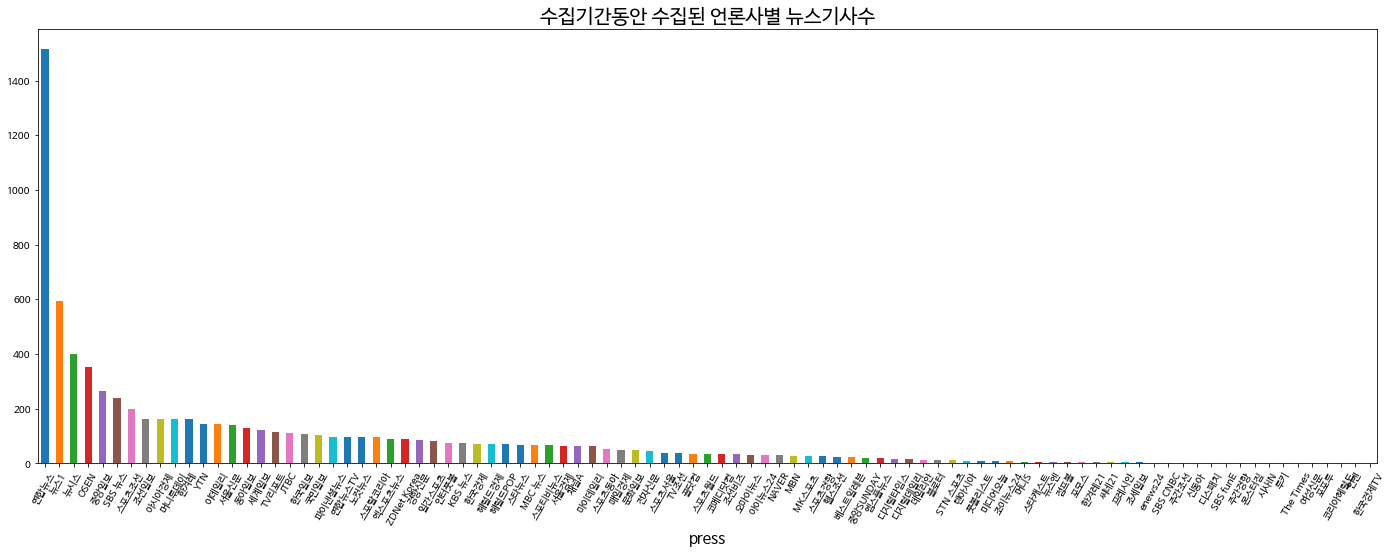

In [523]:
f1 = plt.figure(figsize=(24,8))
plt.title('수집기간동안 수집된 언론사별 뉴스기사수', color='black', fontsize= 20)
count_by_press.plot(kind='bar', rot=60,ax = f1.gca())
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('press',fontsize=15)
plt.show()

언론사 : 연합뉴스, 분야 : 방송/통신
언론사 : 뉴스1, 분야 : 방송/통신
언론사 : 뉴시스, 분야 : 방송/통신
언론사 : OSEN, 분야 : 스포츠/연예
언론사 : 중앙일보, 분야 : 종합
언론사 : SBS 뉴스, 분야 : 방송/통신
언론사 : 스포츠조선, 분야 : 스포츠/연예
언론사 : 조선일보, 분야 : 종합
언론사 : 아시아경제, 분야 : 경제
언론사 : 머니투데이, 분야 : 경제
언론사 : 한겨레, 분야 : 종합
언론사 : YTN, 분야 : 방송/통신
언론사 : 이데일리, 분야 : 경제
언론사 : 서울신문, 분야 : 종합
언론사 : 동아일보, 분야 : 종합
언론사 : 세계일보, 분야 : 종합
언론사 : TV리포트, 분야 : 스포츠/연예
언론사 : JTBC, 분야 : 방송/통신
언론사 : 한국일보, 분야 : 종합
언론사 : 국민일보, 분야 : 종합
언론사 : 파이낸셜뉴스, 분야 : 경제
언론사 : 연합뉴스TV, 분야 : 방송/통신
언론사 : 노컷뉴스, 분야 : 인터넷
언론사 : 스포탈코리아, 분야 : 스포츠/연예
언론사 : 엑스포츠뉴스, 분야 : 스포츠/연예
언론사 : ZDNet Korea, 분야 : IT
언론사 : 경향신문, 분야 : 종합
언론사 : 일간스포츠, 분야 : 스포츠/연예
언론사 : 인터풋볼, 분야 : 스포츠/연예
언론사 : KBS 뉴스, 분야 : 방송/통신
언론사 : 한국경제, 분야 : 경제
언론사 : 헤럴드경제, 분야 : 경제
언론사 : 헤럴드POP, 분야 : 스포츠/연예
언론사 : 스타뉴스, 분야 : 스포츠/연예
언론사 : MBC 뉴스, 분야 : 방송/통신
언론사 : 스포티비뉴스, 분야 : 스포츠/연예
언론사 : 서울경제, 분야 : 경제
언론사 : 채널A, 분야 : 방송/통신
언론사 : 마이데일리, 분야 : 스포츠/연예
언론사 : 스포츠동아, 분야 : 스포츠/연예
언론사 : 매일경제, 분야 : 경제
언론사 : 문화일보, 분야 : 종합
언론사 : 전자신문, 분야 : IT
언론사 : 스포츠서울, 분야 : 스포츠/연예
언론사 : TV

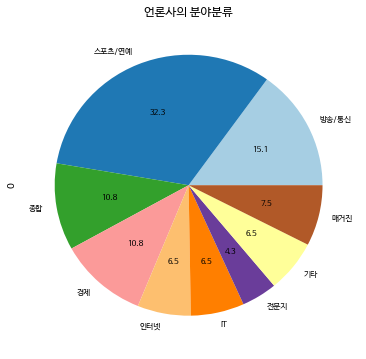

In [519]:
catis = list()
for idx in count_by_press.index:
    if idx in cat_press_in_ranked:
        catis.append(cat_press_in_ranked[idx])
        print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))    
    else:
        catis.append('기타')
        print ('언론사 : {}, 분야 : {}'.format(idx, '기타'))    
catis = pd.DataFrame.from_dict(Counter(catis), orient='index')[0]
catis.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title='언론사의 분야분류')

* 위의 목록에 존재하지 않는 언론사는 기타로 분류

In [417]:
print ('수집기간동안 상위 3위인 연합뉴스, 뉴스1, 뉴시스 언론사의 뉴스기사 비율 : {:0.2f}'.format(count_by_press[:3].sum()/count_by_press.sum()))

수집기간동안 상위 3위인 연합뉴스, 뉴스1, 뉴시스 언론사의 뉴스기사 비율 : 0.33


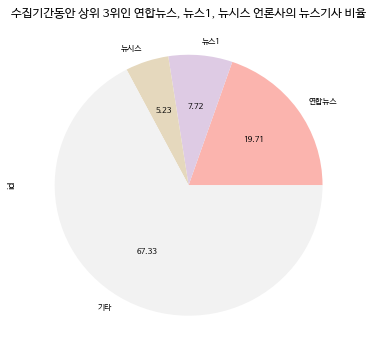

In [453]:
top3 = count_by_press[:3]
top3['기타'] = count_by_press.sum()-count_by_press[:3].sum()
top3.plot.pie(autopct='%.2f', fontsize=8, figsize=(6, 6),colormap = plt.get_cmap('Pastel1'), title = '수집기간동안 상위 3위인 연합뉴스, 뉴스1, 뉴시스 언론사의 뉴스기사 비율')

언론사 : 연합뉴스, 분야 : 방송/통신
언론사 : 뉴스1, 분야 : 방송/통신
언론사 : 뉴시스, 분야 : 방송/통신


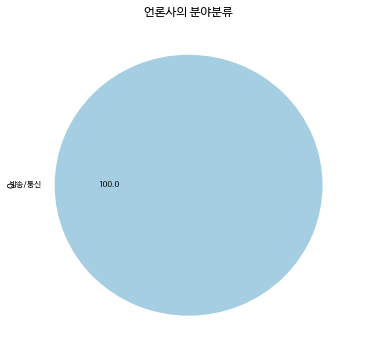

In [513]:
top3cat = list()
for idx in count_by_press[:3].index:
    print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))
    top3cat.append(cat_press_in_ranked[idx])
top3cat = pd.DataFrame.from_dict(Counter(top3cat), orient='index')[0]
top3cat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title='언론사의 분야분류')

* 연합뉴스가 압도적으로 많다.
* 연합뉴스, 뉴스1, 뉴시스
> 연합뉴스는 국가 기간 통신사로 전반적인 뉴스를 다루는 기간이라고 들었는데 뉴스1과 뉴시스는?
> * [연합뉴스](http://www.yonhapnews.co.kr/)
>> 연합뉴스(聯合뉴스)는 방송과 신문, 정부, 포털 사이트, 기타 예약 구독자에게 기사를 공급하는 뉴스통신사  
>> 국내외 취재망을 구축해 제작한 기사를 대한민국의 각종 신문사와 방송사와 행정부 각 부처와 주요 기관, 주요 기업체, 인터넷 매체와 국외 계약 매체에도 공급  
>> 정치, 경제, 사회, 문화. 연예, 스포츠, 레저, 과학, 정보, 지방, 외신에 관계된 국내외 뉴스 하루 3천여 건을 제공  
>> 2003년 제정된 「뉴스통신진흥에관한법률」에 의거해 국가 기간 통신사로 지정됐고 국내에 전문 취재 기자 580여 명과 워싱턴, 파리, 모스크바, 도쿄(東京), 베이징(北京)을 위시해 전 세계 30여개 주요 지역에 특파원과 통신원 60여 명을 파견
> * [뉴시스](http://www.newsis.com)
>>  대한민국의 민영 뉴스통신사  
>> 평일 기준으로 하루 평균 약 9000 건의 외신기사와 2700건의 국내 기사와 사진을 생산.  
>> 본사에 150여 명, 지역본부에 150여 명의 취재기자가 속해 있다.  
> * [뉴스1](http://news1.kr)
>> 대한민국의 민영 뉴스통신사  
>> 기사를 전국의 신문과 방송, 정부 부처, 주요 기관, 기업체, 인터넷 포털사이트 등에 공급  
>> 로이터, AFP 등 외국 뉴스통신사와 제휴해 국제 뉴스를 제공  
>> 서울, 부산·경남, 대구·경북, 인천, 광주·전남, 대전·충남, 울산, 경기, 강원, 충북·세종, 전북, 제주 등 전국 광역시·도 17개 지역에 취재본부 네트워크를 구축해 국내 뉴스도 공급  
* 통신사?
> 독자적인 취재조직을 가지고 수집한 뉴스를 신문사와 방송국에 제공하는 기관
> 대한민국 뉴스 통신사로는 연합뉴스 외에 뉴시스, 뉴스1, 아시아뉴스통신, 포커스뉴스, NSP통신 등  

> 연합뉴스, 뉴스1, 뉴시스는 신문사와 방송국에 뉴스를 신문사와 방송국에 제공하는 기관! 등록된 뉴스가 타 언론사에 비해 많을 수 밖에 없다.

#### 뉴스기사수가 상위 10위내 언론사에 대하여 알아보자

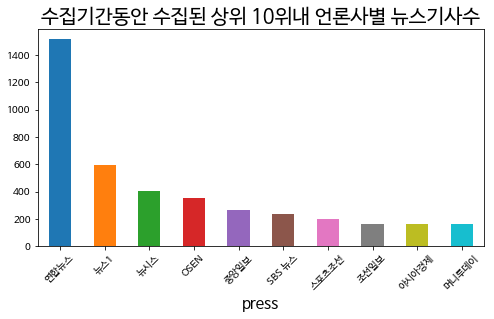

In [525]:
f1 = plt.figure(figsize=(8,4))
plt.title('수집기간동안 수집된 상위 10위내 언론사별 뉴스기사수', color='black', fontsize= 20)
count_by_press[:10].plot(kind='bar', rot=45,ax = f1.gca())
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('press',fontsize=15)
plt.show()

In [420]:
print ('수집기간동안 상위 10위이내 언론사의 뉴스기사 비율 : {:0.2f}'.format(count_by_press[:10].sum()/count_by_press.sum()))

수집기간동안 상위 10위이내 언론사의 뉴스기사 비율 : 0.53


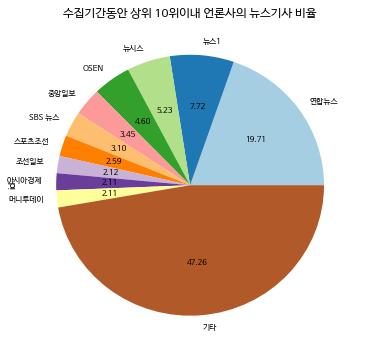

In [526]:
top10 = count_by_press[:10]
top10['기타'] = count_by_press.sum()-count_by_press[:10].sum()
top10.plot.pie(autopct='%.2f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title = '수집기간동안 상위 10위이내 언론사의 뉴스기사 비율')

언론사 : 연합뉴스, 분야 : 방송/통신
언론사 : 뉴스1, 분야 : 방송/통신
언론사 : 뉴시스, 분야 : 방송/통신
언론사 : OSEN, 분야 : 스포츠/연예
언론사 : 중앙일보, 분야 : 종합
언론사 : SBS 뉴스, 분야 : 방송/통신
언론사 : 스포츠조선, 분야 : 스포츠/연예
언론사 : 조선일보, 분야 : 종합
언론사 : 아시아경제, 분야 : 경제
언론사 : 머니투데이, 분야 : 경제


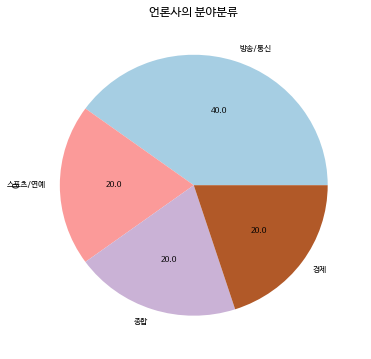

In [527]:
top10cat = list()
for idx in count_by_press[:10].index:
    print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))
    top10cat.append(cat_press_in_ranked[idx])
top10cat = pd.DataFrame.from_dict(Counter(top10cat), orient='index')[0]
top10cat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6),title='언론사의 분야분류')

#### 뉴스기사수가 상위 20위내 언론사에 대하여 알아보자

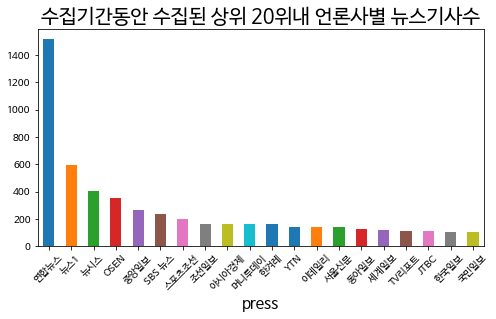

In [521]:
f1 = plt.figure(figsize=(8,4))
plt.title('수집기간동안 수집된 상위 20위내 언론사별 뉴스기사수', color='black', fontsize= 20)
count_by_press[:20].plot(kind='bar', rot=45,ax = f1.gca())
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('press',fontsize=15)
plt.show()

In [381]:
print ('수집기간동안 상위 20위이내 언론사의 뉴스기사 비율 : {:0.2f}'.format(count_by_press[:20].sum()/count_by_press.sum()))

수집기간동안 상위 20위이내 언론사의 뉴스기사 비율 : 0.69


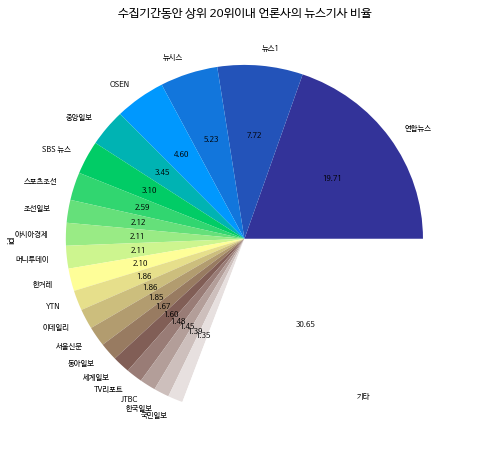

In [529]:
top20 = count_by_press[:20]
top20['기타'] = count_by_press.sum()-count_by_press[:20].sum()
top20.plot.pie(autopct='%.2f', fontsize=7.5, figsize=(8, 8),colormap = plt.get_cmap('terrain'), title = '수집기간동안 상위 20위이내 언론사의 뉴스기사 비율')

언론사 : 연합뉴스, 분야 : 방송/통신
언론사 : 뉴스1, 분야 : 방송/통신
언론사 : 뉴시스, 분야 : 방송/통신
언론사 : OSEN, 분야 : 스포츠/연예
언론사 : 중앙일보, 분야 : 종합
언론사 : SBS 뉴스, 분야 : 방송/통신
언론사 : 스포츠조선, 분야 : 스포츠/연예
언론사 : 조선일보, 분야 : 종합
언론사 : 아시아경제, 분야 : 경제
언론사 : 머니투데이, 분야 : 경제
언론사 : 한겨레, 분야 : 종합
언론사 : YTN, 분야 : 방송/통신
언론사 : 이데일리, 분야 : 경제
언론사 : 서울신문, 분야 : 종합
언론사 : 동아일보, 분야 : 종합
언론사 : 세계일보, 분야 : 종합
언론사 : TV리포트, 분야 : 스포츠/연예
언론사 : JTBC, 분야 : 방송/통신
언론사 : 한국일보, 분야 : 종합
언론사 : 국민일보, 분야 : 종합


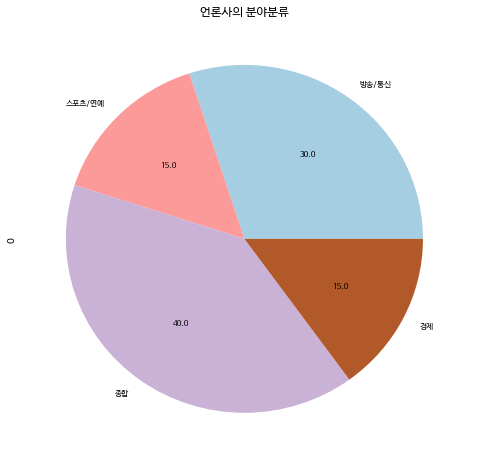

In [516]:
top20cat = list()
for idx in count_by_press[:20].index:
    print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))
    top20cat.append(cat_press_in_ranked[idx])
top20cat = pd.DataFrame.from_dict(Counter(top20cat), orient='index')[0]
top20cat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(8, 8),title='언론사의 분야분류')

### 일별 & 언론별 뉴스기사수

In [540]:
date_press_naver = df_naver.groupby(['date','press'])['id'].count()

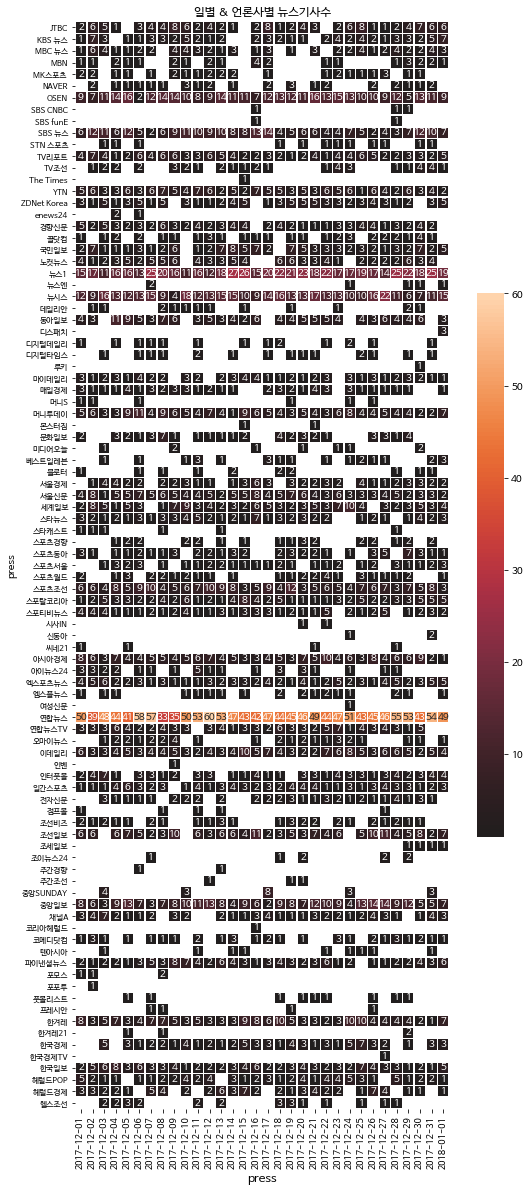

In [654]:
f1 = plt.figure(figsize=(10,20))
plt.title('일별 & 언론사별 뉴스기사수', color='black')
sns.heatmap(date_press_naver.unstack().T, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=f1.gca())
plt.xticks(fontsize=9)
plt.yticks(fontsize=8)
plt.xlabel('press',fontsize=12)
plt.show()

* 알아보기 힘들다
* 언론사의 특정 카테고리 관련 계열 언론, 주간지 또는 월간지의 경우, 특정일에는 없는 경우도 존재함
> * SBS CNBC, SBS funE, The Times, enews24, 디스패치, 머니S, 몬스터짐, 스타캐스트, 시사IN, 신동아, 씨네21, 여성신문, 인벤, 점프볼, 조이뉴스24, 주간경향, 주간조선, 중앙SUNDAY, 코리아헤럴드, 포브스, 포포투, 풋볼리스트, 프레시안, 한겨레21, 한국경제TV 등은 대체로 0이고, 전체적으로 전체중에서 10건 미만의 기사가 등록되어진 것으로 보임

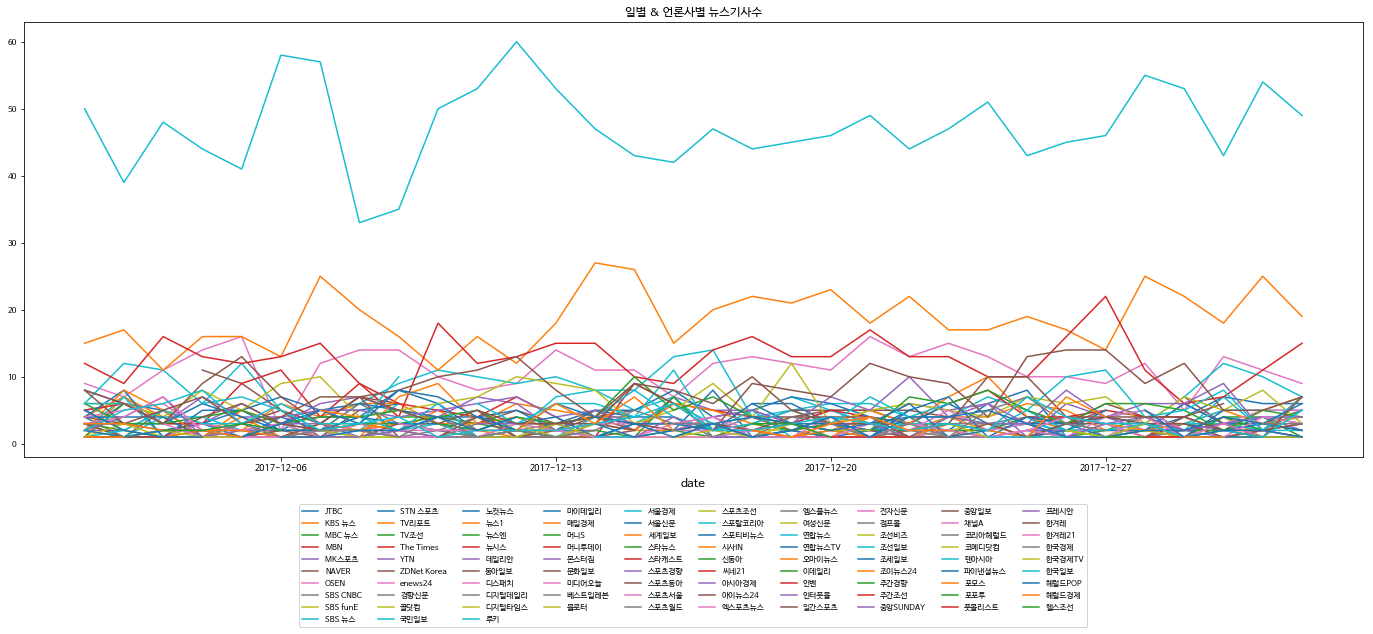

In [546]:
f1 = plt.figure(figsize=(24,8))
plt.title('일별 & 언론사별 뉴스기사수', color='black')
date_press_naver.unstack().plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.4),ncol = 10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=8)
plt.xlabel('date',fontsize=12)
plt.show()

#### * 뉴스 수집기간동안 매일 최소 한건의 기사가 랭킹뉴스에 등록된 언론사

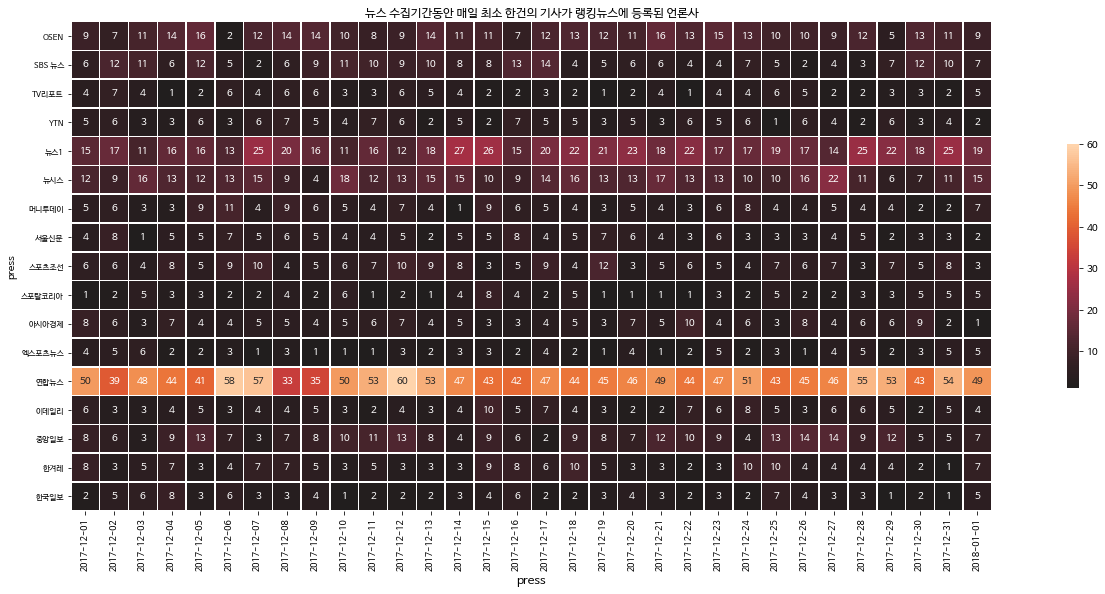

In [548]:
f1 = plt.figure(figsize=(27,9))
plt.title('뉴스 수집기간동안 매일 최소 한건의 기사가 랭킹뉴스에 등록된 언론사', color='black')
sns.heatmap(date_press_naver.unstack().dropna(axis = 1).T, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=f1.gca())
plt.xticks(fontsize=9)
plt.yticks(fontsize=8)
plt.xlabel('press',fontsize=12)
plt.show()

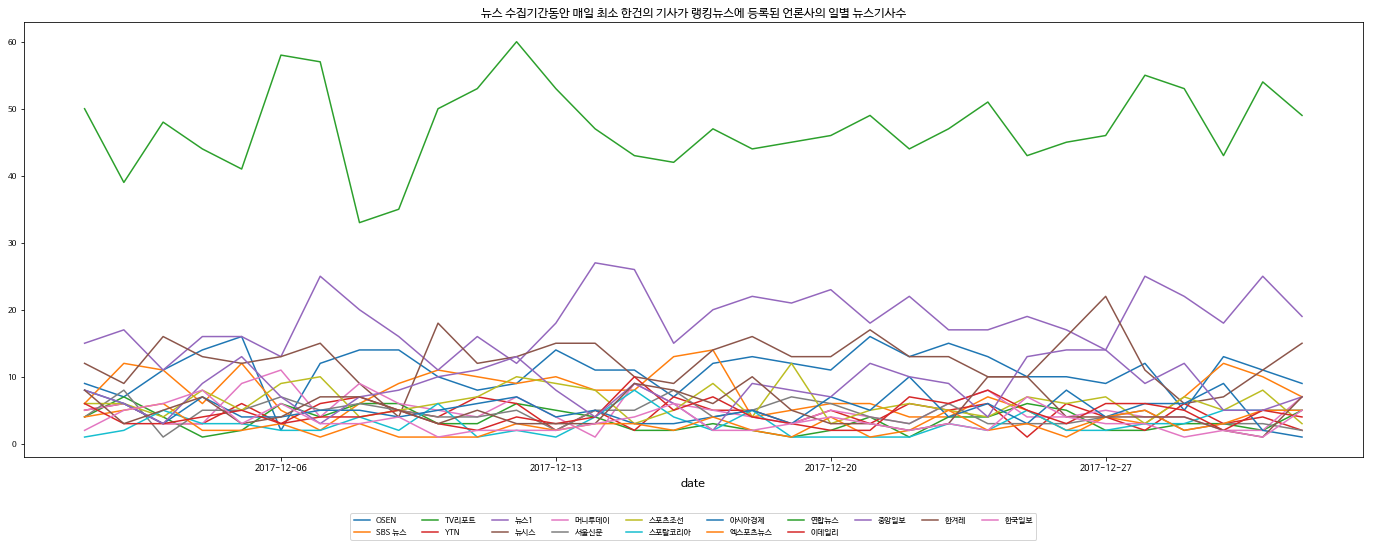

In [657]:
f1 = plt.figure(figsize=(24,8))
plt.title('뉴스 수집기간동안 매일 최소 한건의 기사가 랭킹뉴스에 등록된 언론사의 일별 뉴스기사수', color='black')
date_press_naver.unstack().dropna(axis = 1).plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.2),ncol = 10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=8)
plt.xlabel('date',fontsize=12)
plt.show()

언론사 : OSEN, 분야 : 스포츠/연예
언론사 : SBS 뉴스, 분야 : 방송/통신
언론사 : TV리포트, 분야 : 스포츠/연예
언론사 : YTN, 분야 : 방송/통신
언론사 : 뉴스1, 분야 : 방송/통신
언론사 : 뉴시스, 분야 : 방송/통신
언론사 : 머니투데이, 분야 : 경제
언론사 : 서울신문, 분야 : 종합
언론사 : 스포츠조선, 분야 : 스포츠/연예
언론사 : 스포탈코리아, 분야 : 스포츠/연예
언론사 : 아시아경제, 분야 : 경제
언론사 : 엑스포츠뉴스, 분야 : 스포츠/연예
언론사 : 연합뉴스, 분야 : 방송/통신
언론사 : 이데일리, 분야 : 경제
언론사 : 중앙일보, 분야 : 종합
언론사 : 한겨레, 분야 : 종합
언론사 : 한국일보, 분야 : 종합


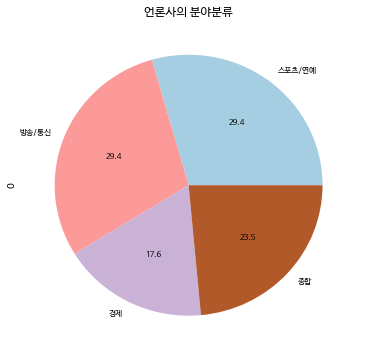

In [658]:
alldaysCat = list()
for idx in date_press_naver.unstack().dropna(axis = 1).columns:
    if idx in cat_press_in_ranked:
        alldaysCat.append(cat_press_in_ranked[idx])
        print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))    
    else:
        alldaysCat.append('기타')
        print ('언론사 : {}, 분야 : {}'.format(idx, '기타'))    
alldaysCat = pd.DataFrame.from_dict(Counter(alldaysCat), orient='index')[0]
alldaysCat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title='언론사의 분야분류')

#### 뉴스량 상위 3, 상위 10, 상위 20 개 언론사를 대상으로 그래프를 그려보자

In [659]:
total_3_press = date_press_naver.unstack().sum(axis = 0).sort_values(ascending=False)[:3].index
total_10_press = date_press_naver.unstack().sum(axis = 0).sort_values(ascending=False)[:10].index
total_20_press = date_press_naver.unstack().sum(axis = 0).sort_values(ascending=False)[:20].index

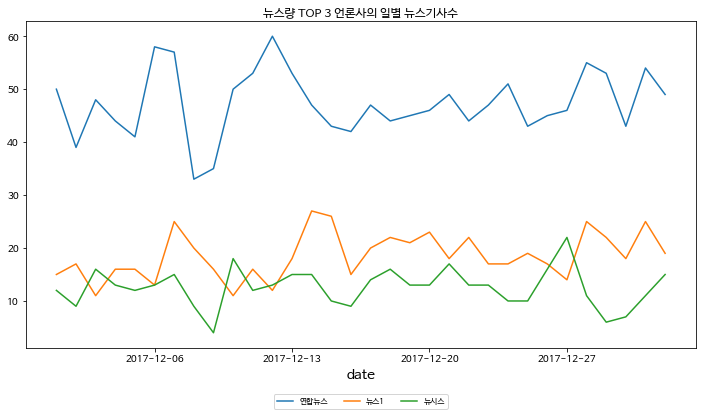

In [660]:
f1 = plt.figure(figsize=(12,6))
plt.title('뉴스량 TOP 3 언론사의 일별 뉴스기사수', color='black')
date_press_naver.unstack().loc[:,total_3_press].plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.2),ncol = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('date',fontsize=14)
plt.show()

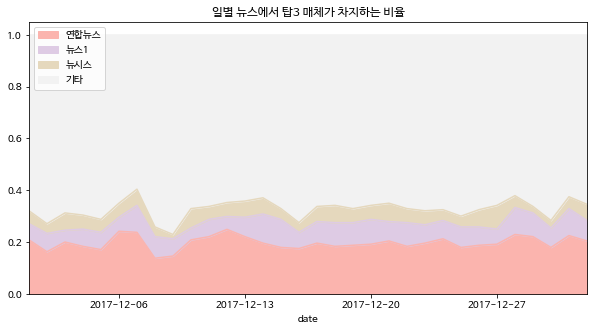

In [661]:
t3p = date_press_naver.unstack().loc[:,total_3_press]
t3p['기타'] = date_press_naver.unstack().sum(axis = 1 ) - t3p.sum(axis = 1)
t3p = t3p.divide(t3p.sum(axis=1), axis=0)
t3p.plot(kind='area',colormap = plt.get_cmap('Pastel1'),figsize=(10,5))
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('일별 뉴스에서 탑3 매체가 차지하는 비율')
plt.show()

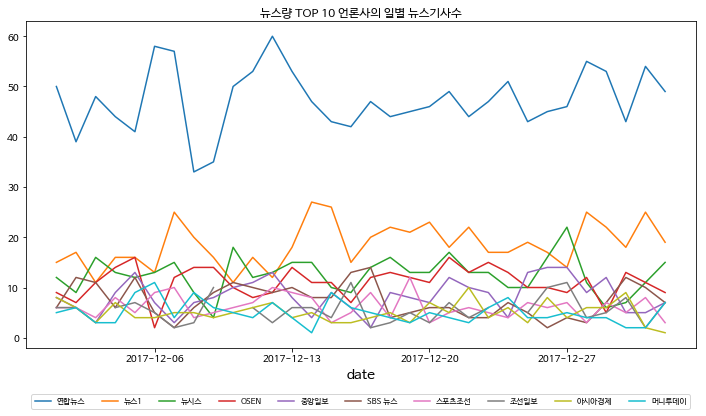

In [662]:
f1 = plt.figure(figsize=(12,6))
plt.title('뉴스량 TOP 10 언론사의 일별 뉴스기사수', color='black')
date_press_naver.unstack().loc[:,total_10_press].plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.2),ncol = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('date',fontsize=14)
plt.show()

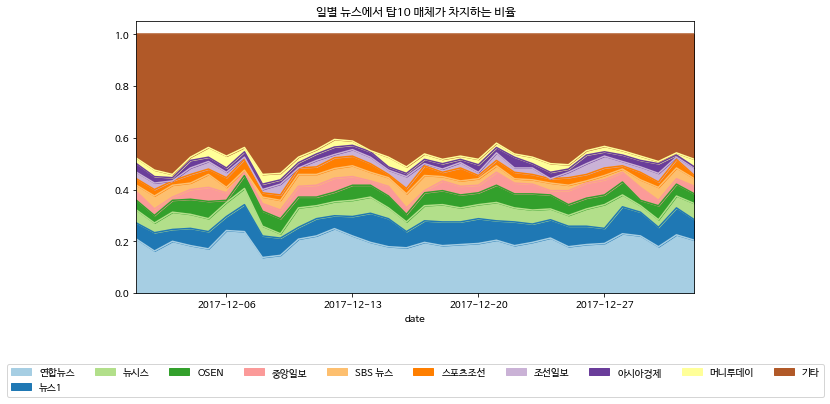

In [663]:
t10p = date_press_naver.unstack().loc[:,total_10_press]
t10p['기타'] = date_press_naver.unstack().sum(axis = 1 ) - t10p.sum(axis = 1)
t10p = t10p.divide(t10p.sum(axis=1), axis=0)
t10p.plot(kind='area',colormap = plt.get_cmap('Paired'),figsize=(10,5))
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.4),ncol = 10)
plt.margins(0,0)
plt.title('일별 뉴스에서 탑10 매체가 차지하는 비율')
plt.show()

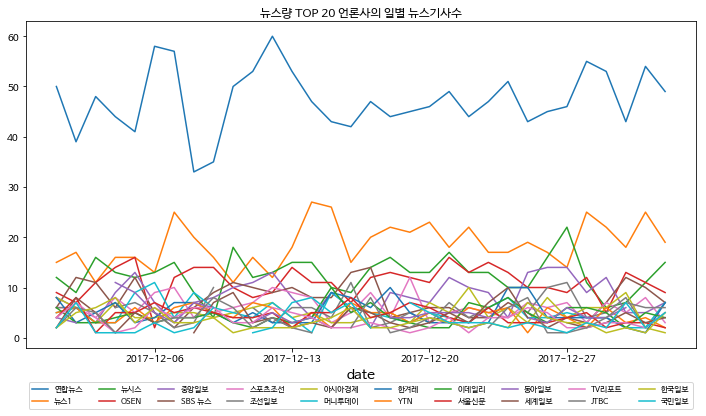

In [664]:
f1 = plt.figure(figsize=(12,6))
plt.title('뉴스량 TOP 20 언론사의 일별 뉴스기사수', color='black')
date_press_naver.unstack().loc[:,total_20_press].plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.2),ncol = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('date',fontsize=14)
plt.show()

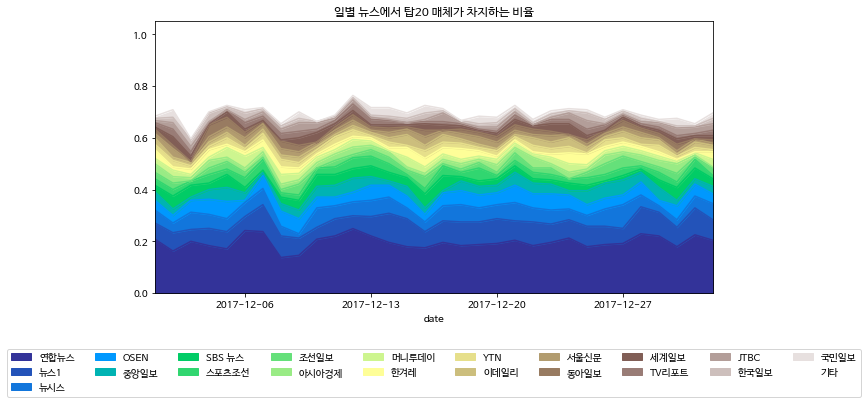

In [665]:
t20p = date_press_naver.unstack().loc[:,total_20_press]
t20p['기타'] = date_press_naver.unstack().sum(axis = 1 ) - t20p.sum(axis = 1)
t20p = t20p.divide(t20p.sum(axis=1), axis=0)
t20p.plot(kind='area',colormap = plt.get_cmap('terrain'),figsize=(10,5))
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.4),ncol = 10)
plt.margins(0,0)
plt.title('일별 뉴스에서 탑20 매체가 차지하는 비율')
plt.show()

* 상위 20위까지 언론매체가 일별로 점유율이 평균적으로 0.6 이상인 것으로 판단됨

### 카테고리별 & 언론사별 뉴스기사

In [666]:
category_press_naver = df_naver.groupby(['category','press'])['id'].count()

In [667]:
sortedcpn = category_press_naver.unstack().loc[:,date_press_naver.unstack().sum(axis = 0).sort_values(ascending=False).index]

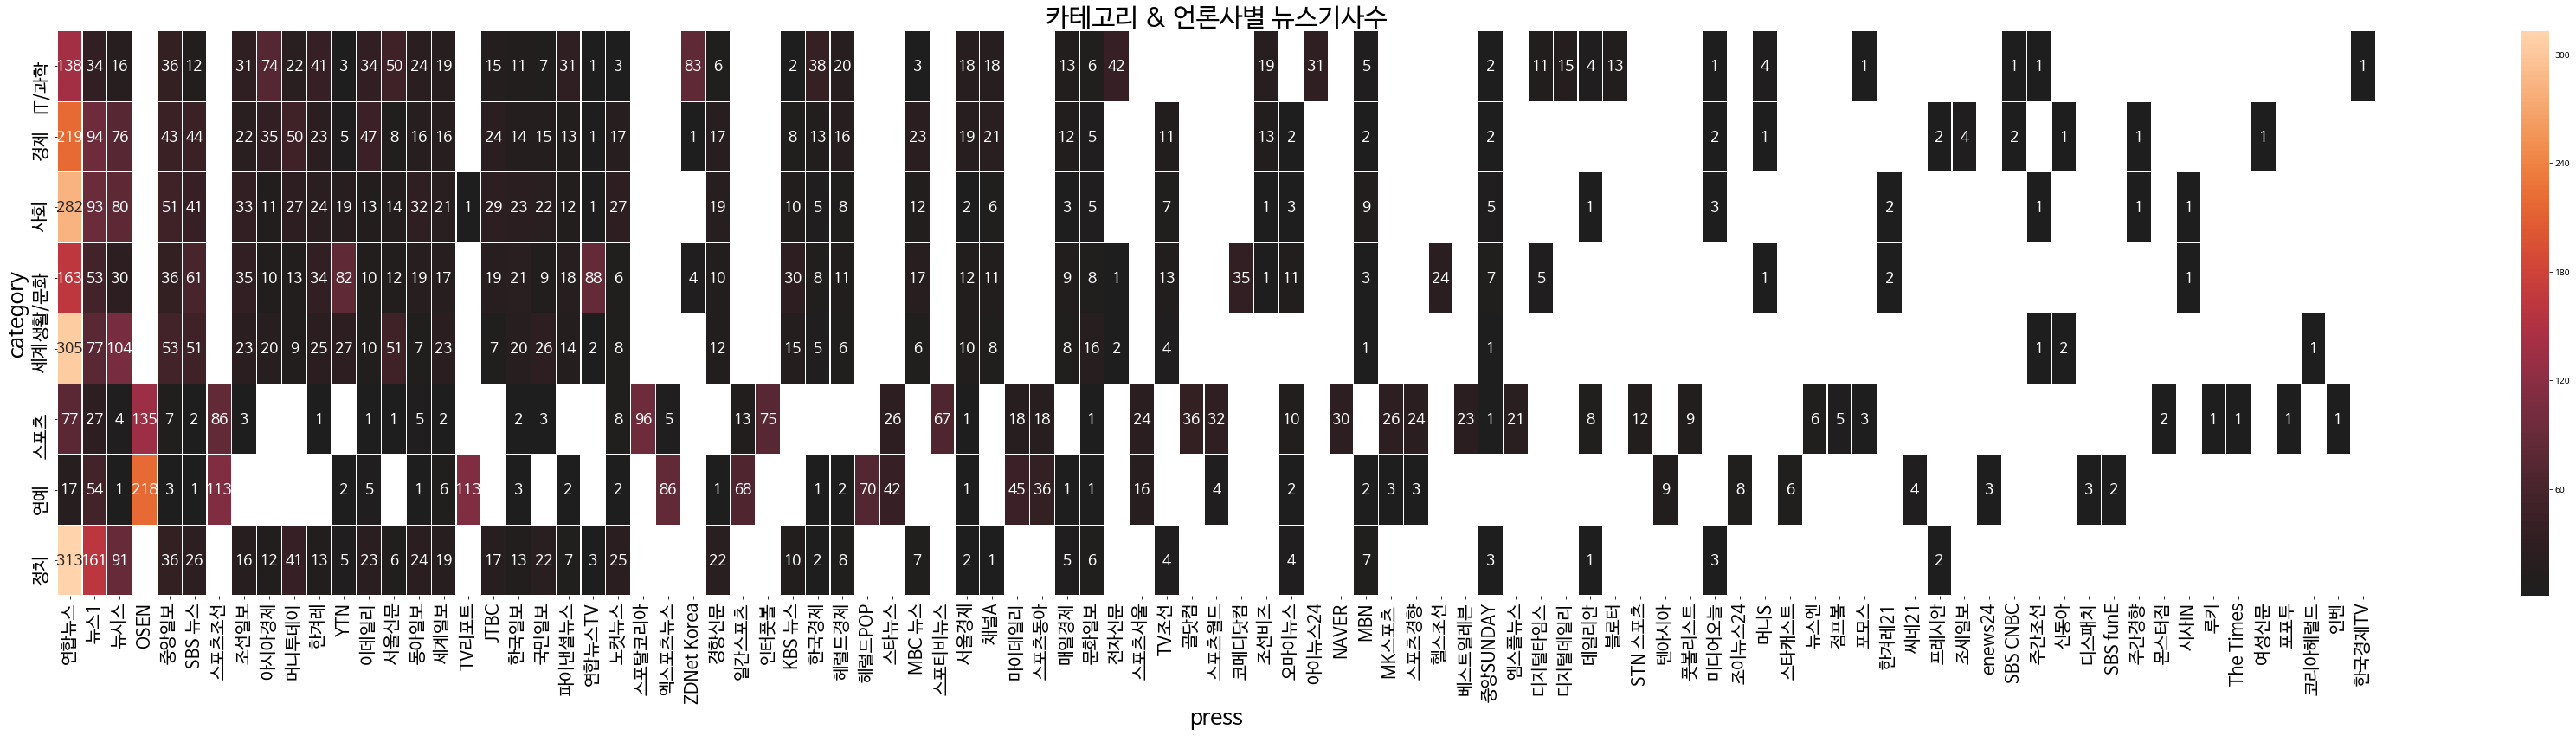

In [668]:
f1 = plt.figure(figsize=(60,12))
plt.title('카테고리 & 언론사별 뉴스기사수', color='black',fontsize=30)
sns.heatmap(sortedcpn, center=0, annot=True, fmt='.0f',annot_kws={"size": 17.5},
            linewidths=.25, cbar_kws={"shrink": 1}, ax=f1.gca())
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('press',fontsize=25)
plt.ylabel('category',fontsize=25)
plt.show()

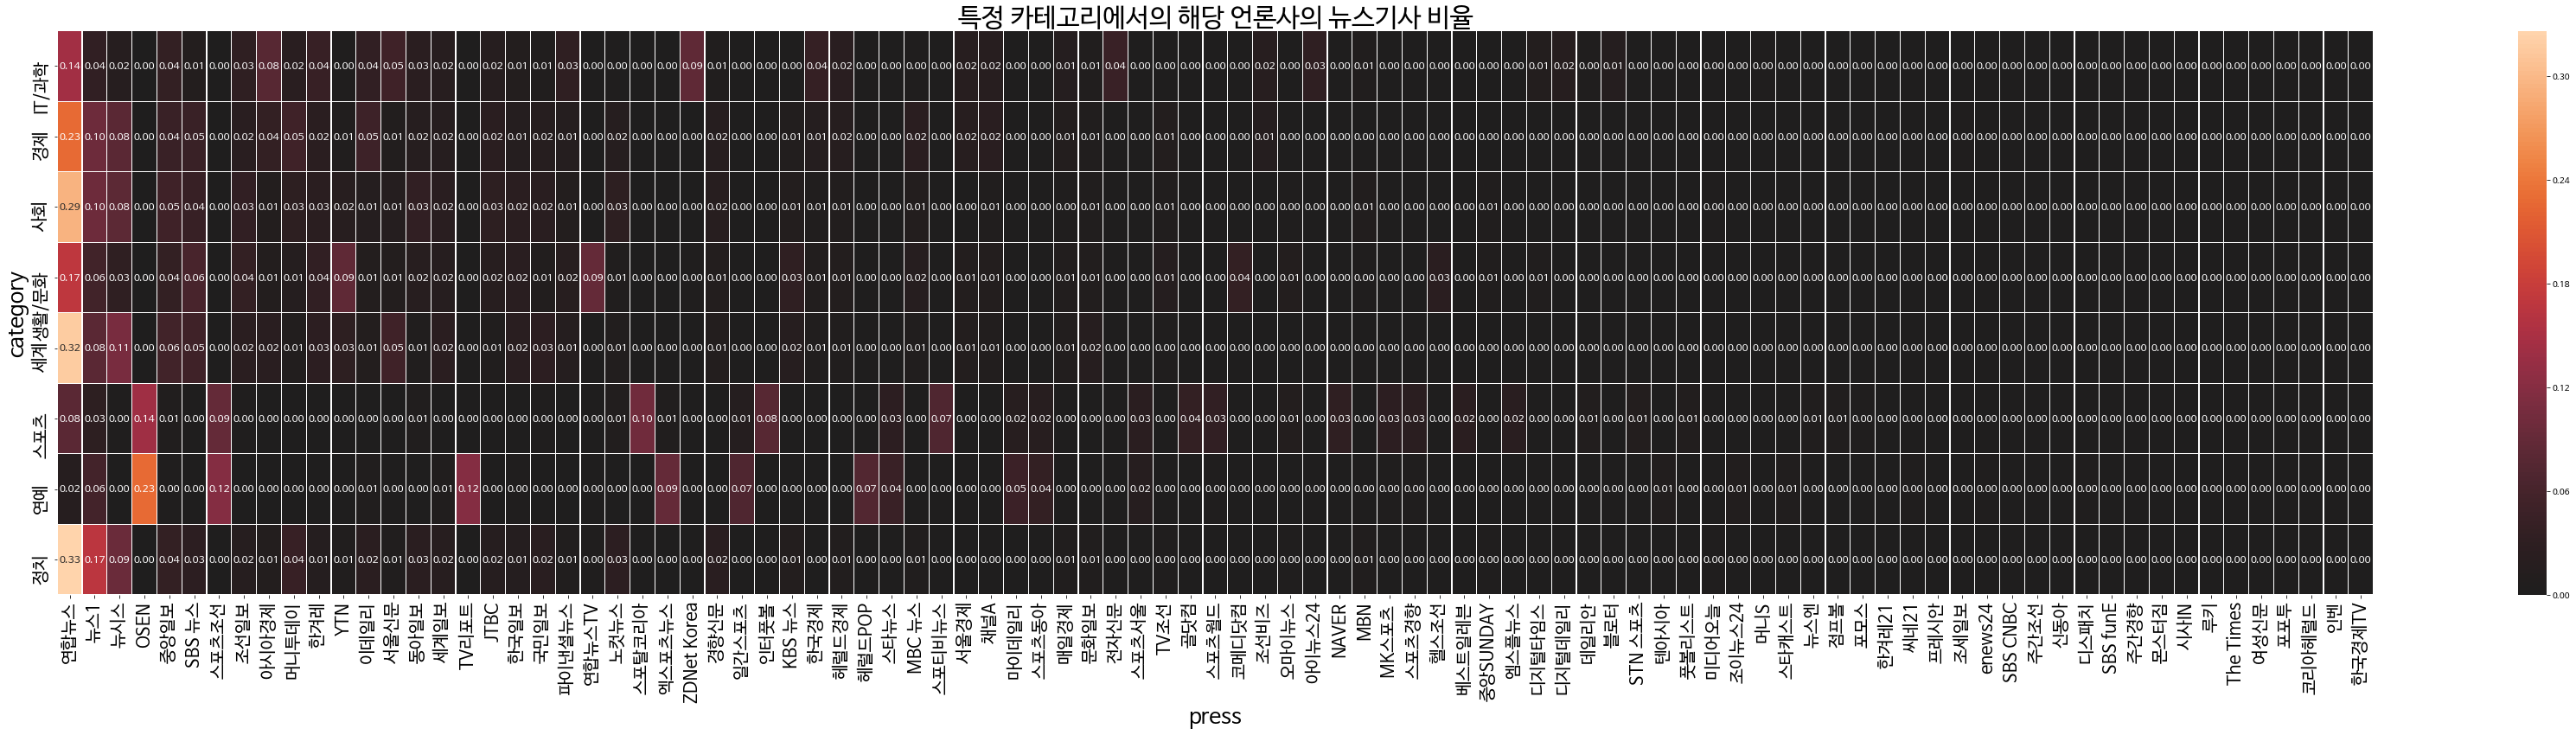

In [688]:
f1 = plt.figure(figsize=(60,12))
plt.title('특정 카테고리에서의 해당 언론사의 뉴스기사 비율', color='black',fontsize=30)
sns.heatmap(sortedcpn.fillna(0).divide(sortedcpn.sum(axis = 1),axis = 0), center=0, annot=True, fmt='.2f',annot_kws={"size": 12},
            linewidths=.25, cbar_kws={"shrink": 1}, ax=f1.gca())
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('press',fontsize=25)
plt.ylabel('category',fontsize=25)
plt.show()

#### * 모든 카테고리(정치, 연예, 스포츠, 세계, 생활/문화, 사회, 경제, IT/과학)에 뉴스 기사가 최소 하나가 있는 언론매체

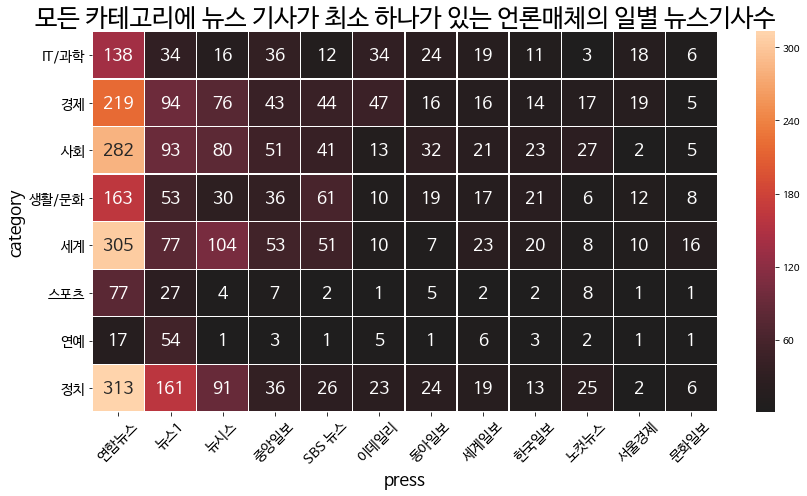

In [670]:
allCatPress = sortedcpn.dropna(axis = 1)
f1 = plt.figure(figsize=(14,7))
plt.title('모든 카테고리에 뉴스 기사가 최소 하나가 있는 언론매체의 일별 뉴스기사수', color='black',fontsize=25)
sns.heatmap(allCatPress, center=0, annot=True, fmt='.0f',annot_kws={"size": 17.5},
            linewidths=.25, cbar_kws={"shrink": 1}, ax=f1.gca())
plt.xticks(fontsize=14,rotation=45)
plt.yticks(fontsize=14,rotation=0)
plt.xlabel('press',fontsize=17)
plt.ylabel('category',fontsize=17)
plt.show()

언론사 : 연합뉴스, 분야 : 방송/통신
언론사 : 뉴스1, 분야 : 방송/통신
언론사 : 뉴시스, 분야 : 방송/통신
언론사 : 중앙일보, 분야 : 종합
언론사 : SBS 뉴스, 분야 : 방송/통신
언론사 : 이데일리, 분야 : 경제
언론사 : 동아일보, 분야 : 종합
언론사 : 세계일보, 분야 : 종합
언론사 : 한국일보, 분야 : 종합
언론사 : 노컷뉴스, 분야 : 인터넷
언론사 : 서울경제, 분야 : 경제
언론사 : 문화일보, 분야 : 종합


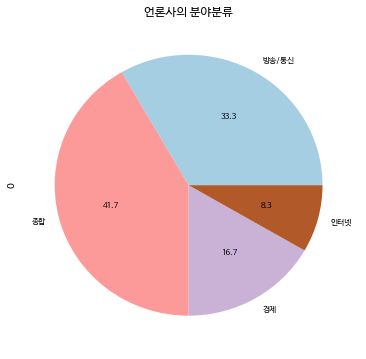

In [689]:
allCat = list()
for idx in allCatPress.columns:
    if idx in cat_press_in_ranked:
        allCat.append(cat_press_in_ranked[idx])
        print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))    
    else:
        allCat.append('기타')
        print ('언론사 : {}, 분야 : {}'.format(idx, '기타'))    
allCat = pd.DataFrame.from_dict(Counter(allCat), orient='index')[0]
allCat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title='언론사의 분야분류')

#### * 모든 카테고리중에서 특정 카테고리에만 뉴스기사가 최소 1개가 나오는 언론매체

In [634]:
pressList = list()
for idx in sortedcpn.columns:
    x = sortedcpn.loc[:,idx]
    if x.isna().sum() == 7:
        pressList.append(idx)
print (len(pressList))

33


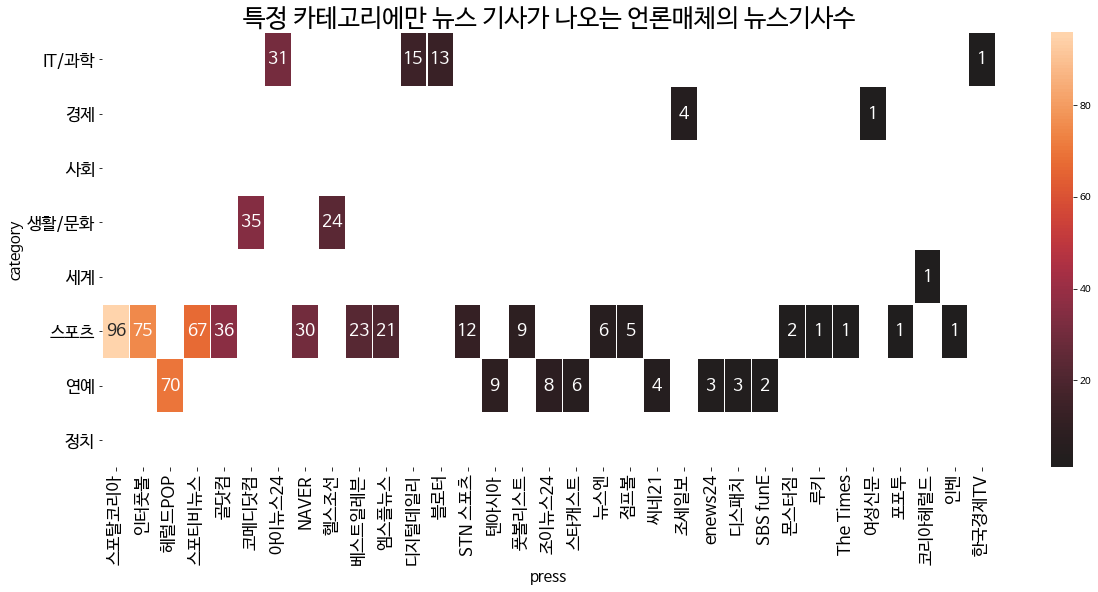

In [635]:
f1 = plt.figure(figsize=(20,8))
plt.title('특정 카테고리에만 뉴스 기사가 나오는 언론매체의 뉴스기사수', color='black',fontsize=25)
sns.heatmap(sortedcpn.loc[:,pressList], center=0, annot=True, fmt='.0f',annot_kws={"size": 17.5},
            linewidths=.25, cbar_kws={"shrink": 1}, ax=f1.gca())
plt.xticks(fontsize=17)
plt.yticks(fontsize=17,rotation=0)
plt.xlabel('press',fontsize=15)
plt.ylabel('category',fontsize=15)
plt.show()

언론사 : 스포탈코리아, 분야 : 스포츠/연예
언론사 : 인터풋볼, 분야 : 스포츠/연예
언론사 : 헤럴드POP, 분야 : 스포츠/연예
언론사 : 스포티비뉴스, 분야 : 스포츠/연예
언론사 : 골닷컴, 분야 : 스포츠/연예
언론사 : 코메디닷컴, 분야 : 전문지
언론사 : 아이뉴스24, 분야 : IT
언론사 : NAVER, 분야 : 기타
언론사 : 헬스조선, 분야 : 전문지
언론사 : 베스트일레븐, 분야 : 스포츠/연예
언론사 : 엠스플뉴스, 분야 : 스포츠/연예
언론사 : 디지털데일리, 분야 : IT
언론사 : 블로터, 분야 : IT
언론사 : STN 스포츠, 분야 : 기타
언론사 : 텐아시아, 분야 : 스포츠/연예
언론사 : 풋볼리스트, 분야 : 스포츠/연예
언론사 : 조이뉴스24, 분야 : 스포츠/연예
언론사 : 스타캐스트, 분야 : 스포츠/연예
언론사 : 뉴스엔, 분야 : 스포츠/연예
언론사 : 점프볼, 분야 : 스포츠/연예
언론사 : 씨네21, 분야 : 매거진
언론사 : 조세일보, 분야 : 경제
언론사 : enews24, 분야 : 스포츠/연예
언론사 : 디스패치, 분야 : 스포츠/연예
언론사 : SBS funE, 분야 : 스포츠/연예
언론사 : 몬스터짐, 분야 : 기타
언론사 : 루키, 분야 : 기타
언론사 : The Times, 분야 : 기타
언론사 : 여성신문, 분야 : 전문지
언론사 : 포포투, 분야 : 스포츠/연예
언론사 : 코리아헤럴드, 분야 : 전문지
언론사 : 인벤, 분야 : 스포츠/연예
언론사 : 한국경제TV, 분야 : 방송/통신


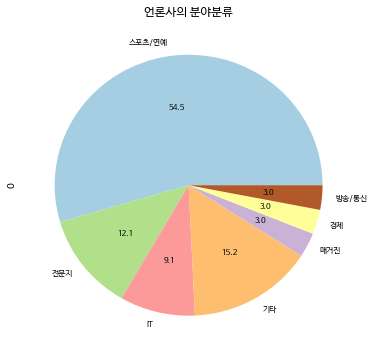

In [691]:
specificCat = list()
for idx in pressList:
    if idx in cat_press_in_ranked:
        specificCat.append(cat_press_in_ranked[idx])
        print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))    
    else:
        specificCat.append('기타')
        print ('언론사 : {}, 분야 : {}'.format(idx, '기타'))    
specificCat = pd.DataFrame.from_dict(Counter(specificCat), orient='index')[0]
specificCat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title='언론사의 분야분류')

* 스포츠에 특화된 언론매체가 많은 것으로 판달할 수 있음
> 단일 카테고리에만 뉴스기사가 게재된 언론사 33개중에서 16개가 스포츠이고 8개가 연예임
> * 스포츠
>> 스포탈코리아, 인터풋볼, 스포티비뉴스, 골닷컴, NAVER, 베스트일레븐, 엠스플뉴스, STN스포츠, 풋볼리스트, 뉴스엔, 점프볼, 몬스터짐, 루키, The Times, 포포투, 인벤
> * 연예
>> 헤럴드POP, 텐아시아, 조이뉴스24, 스타캐스트, 씨네21, enews24, 디스패치, SBS funE

이 결과만 봐서는 위에 나온 언론사가 특정 카테고리의 뉴스만 다루는 것으로 결론 지을 수는 없다

#### * 연예 & 스포츠에 특화된 언론매체

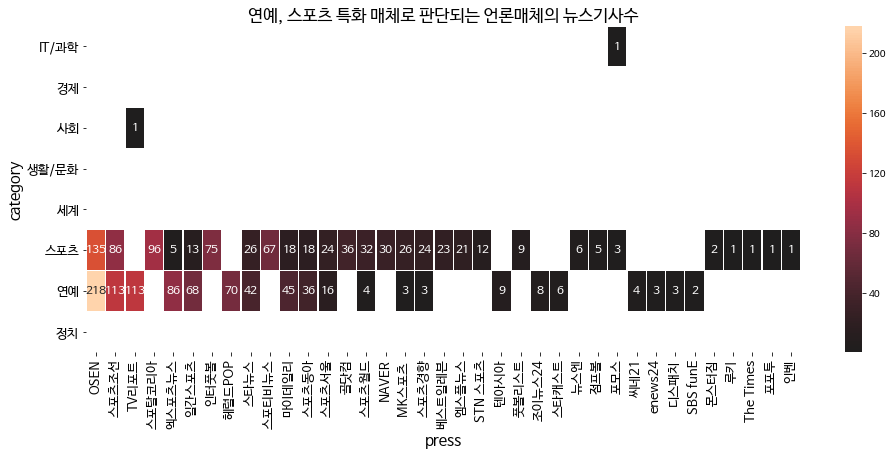

In [693]:
f1 = plt.figure(figsize=(16,6))
plt.title('연예, 스포츠 특화 매체로 판단되는 언론매체의 뉴스기사수', color='black',fontsize=17)
sns.heatmap(sortedcpn.loc[:,fis.columns], center=0, annot=True, fmt='.0f',annot_kws={"size": 12},
            linewidths=.25, cbar_kws={"shrink": 1}, ax=f1.gca())
plt.xticks(fontsize=13)
plt.yticks(fontsize=13,rotation=0)
plt.xlabel('press',fontsize=15)
plt.ylabel('category',fontsize=15)
plt.show()

In [692]:
sePress = sortedcpn.loc[:,sortedcpn.loc[['스포츠','연예'],:].sum()!=0]
fis= sePress.loc[:,sePress.loc[sePress.index.difference(['스포츠','연예']),:].sum(axis = 0) <=1]
fis.columns

Index(['OSEN', '스포츠조선', 'TV리포트', '스포탈코리아', '엑스포츠뉴스', '일간스포츠', '인터풋볼', '헤럴드POP',
       '스타뉴스', '스포티비뉴스', '마이데일리', '스포츠동아', '스포츠서울', '골닷컴', '스포츠월드', 'NAVER',
       'MK스포츠 ', '스포츠경향', '베스트일레븐', '엠스플뉴스', 'STN 스포츠', '텐아시아', '풋볼리스트',
       '조이뉴스24', '스타캐스트', '뉴스엔', '점프볼', '포모스', '씨네21', 'enews24', '디스패치',
       'SBS funE', '몬스터짐', '루키', 'The Times', '포포투', '인벤'],
      dtype='object', name='press')

* 연예, 스포츠 특화 매체로 판단되는 언론매체
> OSEN, 스포츠조선, TV리포트, 스포탈코리아, 엑스포츠뉴스, 일간스포츠, 인터풋볼, 헤럴드POP, 스타뉴스, 스포티비뉴스, 마이데일리, 스포츠동아, 스포츠서울, 골닷컴, 스포츠월드, NAVER, MK스포츠, 스포츠경향, 베스트일레븐, 엠스플뉴스, STN 스포츠, 텐아시아, 풋볼리스트, 조이뉴스24, 스타캐스트, 뉴스엔, 점프볼, 포모스, 씨네21, enews24, 디스패치, SBS funE, 몬스터짐, 루키, The Times, 포포투, 인벤 등의 매체는 스포츠나 연예쪽에 특화된 매체인 것으로 판단됨. 
> NAVER의 경우, NAVER 자체의 전문가칼럼 또는 NAVER에서만 제공되는 뉴스정보인 것으로 판단됨

언론사 : OSEN, 분야 : 스포츠/연예
언론사 : 스포츠조선, 분야 : 스포츠/연예
언론사 : TV리포트, 분야 : 스포츠/연예
언론사 : 스포탈코리아, 분야 : 스포츠/연예
언론사 : 엑스포츠뉴스, 분야 : 스포츠/연예
언론사 : 일간스포츠, 분야 : 스포츠/연예
언론사 : 인터풋볼, 분야 : 스포츠/연예
언론사 : 헤럴드POP, 분야 : 스포츠/연예
언론사 : 스타뉴스, 분야 : 스포츠/연예
언론사 : 스포티비뉴스, 분야 : 스포츠/연예
언론사 : 마이데일리, 분야 : 스포츠/연예
언론사 : 스포츠동아, 분야 : 스포츠/연예
언론사 : 스포츠서울, 분야 : 스포츠/연예
언론사 : 골닷컴, 분야 : 스포츠/연예
언론사 : 스포츠월드, 분야 : 스포츠/연예
언론사 : NAVER, 분야 : 기타
언론사 : MK스포츠 , 분야 : 기타
언론사 : 스포츠경향, 분야 : 스포츠/연예
언론사 : 베스트일레븐, 분야 : 스포츠/연예
언론사 : 엠스플뉴스, 분야 : 스포츠/연예
언론사 : STN 스포츠, 분야 : 기타
언론사 : 텐아시아, 분야 : 스포츠/연예
언론사 : 풋볼리스트, 분야 : 스포츠/연예
언론사 : 조이뉴스24, 분야 : 스포츠/연예
언론사 : 스타캐스트, 분야 : 스포츠/연예
언론사 : 뉴스엔, 분야 : 스포츠/연예
언론사 : 점프볼, 분야 : 스포츠/연예
언론사 : 포모스, 분야 : 스포츠/연예
언론사 : 씨네21, 분야 : 매거진
언론사 : enews24, 분야 : 스포츠/연예
언론사 : 디스패치, 분야 : 스포츠/연예
언론사 : SBS funE, 분야 : 스포츠/연예
언론사 : 몬스터짐, 분야 : 기타
언론사 : 루키, 분야 : 기타
언론사 : The Times, 분야 : 기타
언론사 : 포포투, 분야 : 스포츠/연예
언론사 : 인벤, 분야 : 스포츠/연예


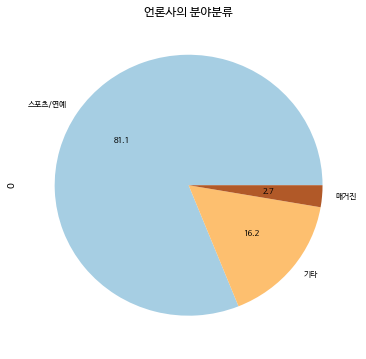

In [696]:
esCat = list()
for idx in fis.columns:
    if idx in cat_press_in_ranked:
        esCat.append(cat_press_in_ranked[idx])
        print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))    
    else:
        esCat.append('기타')
        print ('언론사 : {}, 분야 : {}'.format(idx, '기타'))    
esCat = pd.DataFrame.from_dict(Counter(esCat), orient='index')[0]
esCat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title='언론사의 분야분류')

#### * 정치, 경제, 세계, 생활/문화, IT/과학, 사회 분야 각각에서 최소 1개씩 뉴스기사가 있는 언론매체

In [713]:
totalPress = sortedcpn.loc[sortedcpn.index.difference(['스포츠','연예']),:].dropna(axis = 1)

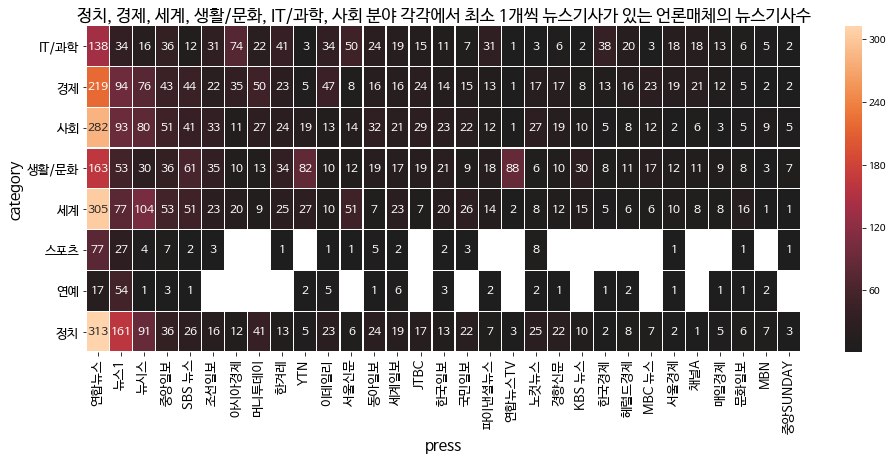

In [716]:
f1 = plt.figure(figsize=(16,6))
plt.title('정치, 경제, 세계, 생활/문화, IT/과학, 사회 분야 각각에서 최소 1개씩 뉴스기사가 있는 언론매체의 뉴스기사수', color='black',fontsize=17)
sns.heatmap(sortedcpn.loc[:,totalPress.columns], center=0, annot=True, fmt='.0f',annot_kws={"size": 12},
            linewidths=.25, cbar_kws={"shrink": 1}, ax=f1.gca())
plt.xticks(fontsize=13)
plt.yticks(fontsize=13,rotation=0)
plt.xlabel('press',fontsize=15)
plt.ylabel('category',fontsize=15)
plt.show()


언론사 : 연합뉴스, 분야 : 방송/통신
언론사 : 뉴스1, 분야 : 방송/통신
언론사 : 뉴시스, 분야 : 방송/통신
언론사 : 중앙일보, 분야 : 종합
언론사 : SBS 뉴스, 분야 : 방송/통신
언론사 : 조선일보, 분야 : 종합
언론사 : 아시아경제, 분야 : 경제
언론사 : 머니투데이, 분야 : 경제
언론사 : 한겨레, 분야 : 종합
언론사 : YTN, 분야 : 방송/통신
언론사 : 이데일리, 분야 : 경제
언론사 : 서울신문, 분야 : 종합
언론사 : 동아일보, 분야 : 종합
언론사 : 세계일보, 분야 : 종합
언론사 : JTBC, 분야 : 방송/통신
언론사 : 한국일보, 분야 : 종합
언론사 : 국민일보, 분야 : 종합
언론사 : 파이낸셜뉴스, 분야 : 경제
언론사 : 연합뉴스TV, 분야 : 방송/통신
언론사 : 노컷뉴스, 분야 : 인터넷
언론사 : 경향신문, 분야 : 종합
언론사 : KBS 뉴스, 분야 : 방송/통신
언론사 : 한국경제, 분야 : 경제
언론사 : 헤럴드경제, 분야 : 경제
언론사 : MBC 뉴스, 분야 : 방송/통신
언론사 : 서울경제, 분야 : 경제
언론사 : 채널A, 분야 : 방송/통신
언론사 : 매일경제, 분야 : 경제
언론사 : 문화일보, 분야 : 종합
언론사 : MBN, 분야 : 방송/통신
언론사 : 중앙SUNDAY, 분야 : 매거진


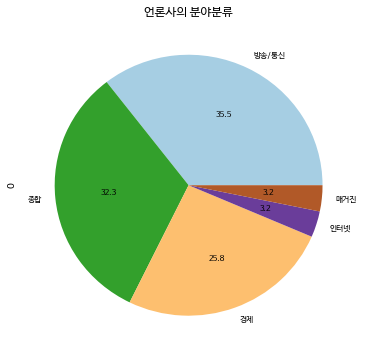

In [717]:
notesCat = list()
for idx in totalPress.columns:
    if idx in cat_press_in_ranked:
        notesCat.append(cat_press_in_ranked[idx])
        print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))    
    else:
        notesCat.append('기타')
        print ('언론사 : {}, 분야 : {}'.format(idx, '기타'))    
notesCat = pd.DataFrame.from_dict(Counter(notesCat), orient='index')[0]
notesCat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title='언론사의 분야분류')

### 카테고리별로 일별 & 언론사별 뉴스기사

In [719]:
date_category_naver = df_naver.groupby(['category','date','press']).count()['id'].unstack()

#### 카테고리별로 전체가 NaN값인 것은 제외

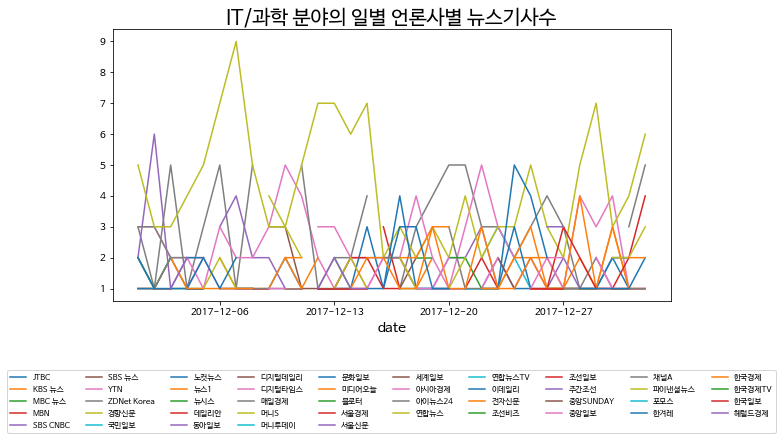

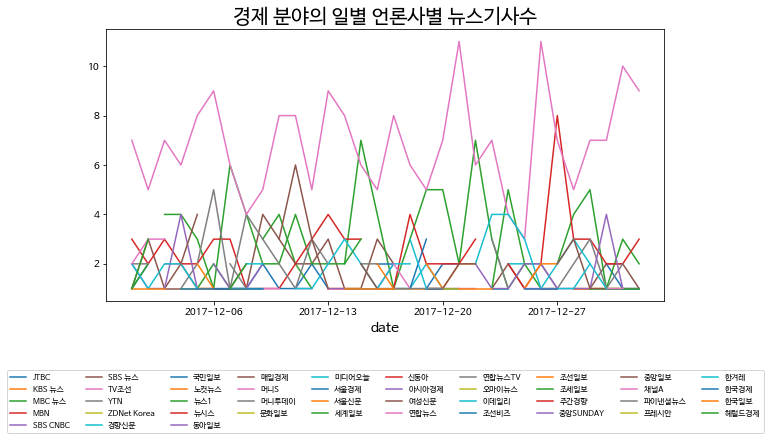

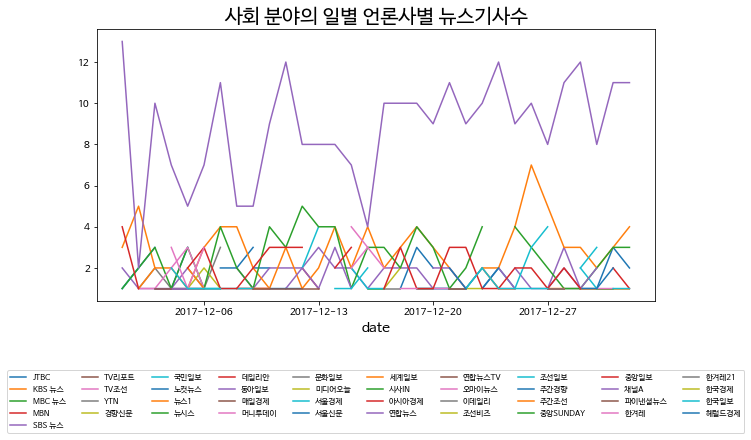

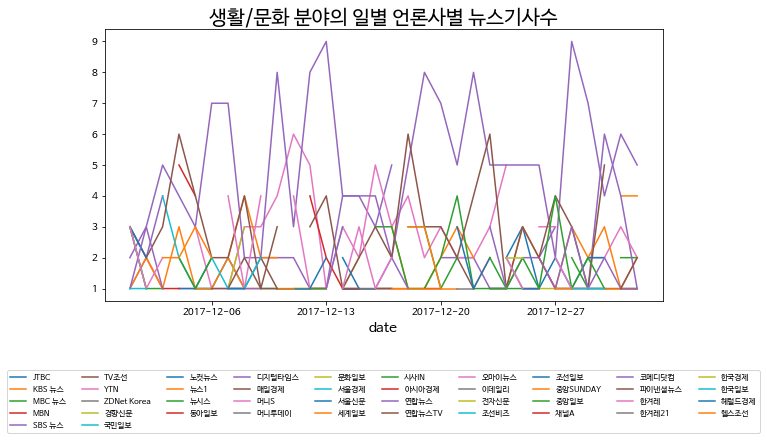

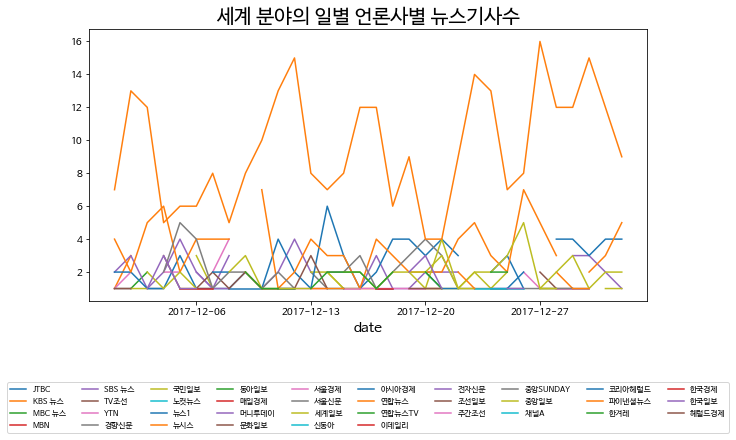

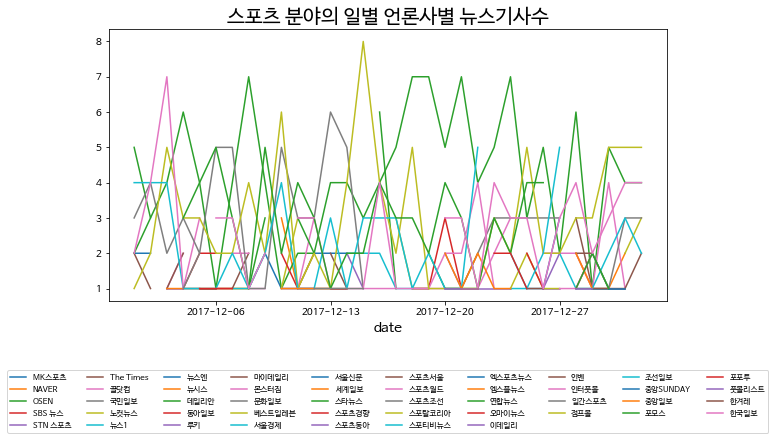

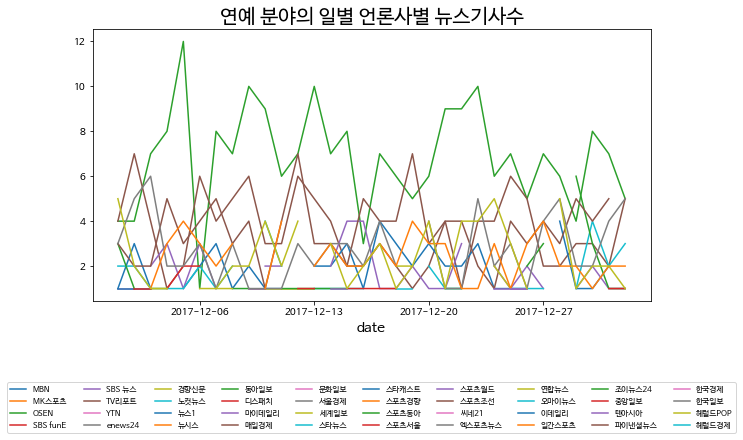

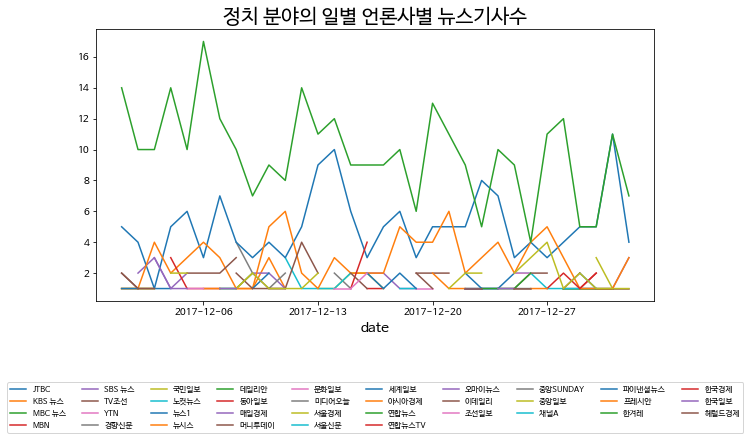

In [737]:
for idx in date_category_naver.index.levels[0]:
    f1 = plt.figure(figsize=(10,5))
    plt.title('{} 분야의 일별 언론사별 뉴스기사수'.format(idx), color='black', fontsize = 20)
    d = date_category_naver.loc[idx,:]
    d.dropna(axis = 1,thresh=1,inplace=True)
    d.plot(kind='line',ax=f1.gca())
    plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.5),ncol = 10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('date',fontsize=14)
    plt.show()

## 댓글 분석

### 요일별 정리

In [744]:
group_by_date = df_naver.groupby('date')['number_of_comment', 'number_of_crawled_comment']

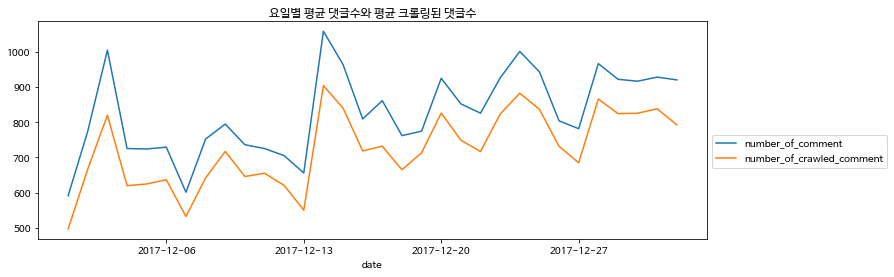

In [745]:
f = plt.figure(figsize=(12,4))
plt.title('요일별 평균 댓글수와 평균 크롤링된 댓글수', color='black')
group_by_date.mean().plot(kind='line', ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

* 등록된 댓글수와 실제 크롤링된 댓글수가 차이를 보이는 것은 작성자가 삭제하였거나, 스팸신고, 타 사용자의 신고로 삭제된 댓글이 존재하기 때문임

### 요일별 & 카테고리별 정리

In [747]:
group_by_date_category = df_naver.groupby(['date', 'category'])['number_of_comment', 'number_of_crawled_comment']

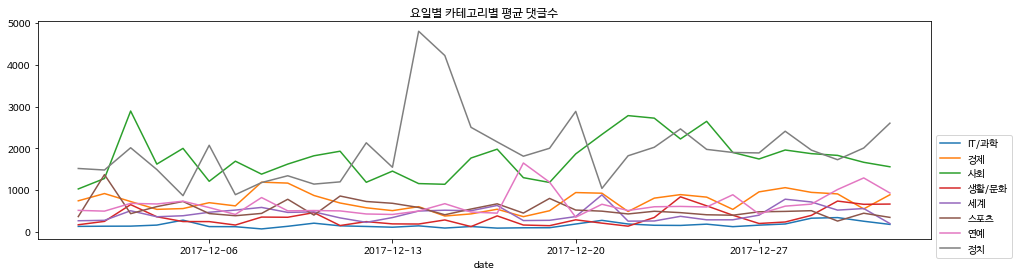

In [748]:
f = plt.figure(figsize=(16,4))
plt.title('요일별 카테고리별 평균 댓글수', color='black')
group_by_date_category.mean()['number_of_comment'].unstack().plot(ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

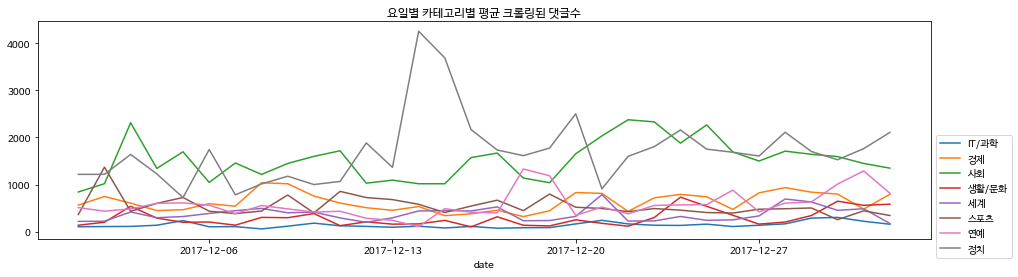

In [749]:
f = plt.figure(figsize=(16,4))
plt.title('요일별 카테고리별 평균 크롤링된 댓글수', color='black')
group_by_date_category.mean()['number_of_crawled_comment'].unstack().plot(kind='line', ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

### 카테고리별 정리

In [751]:
group_by_category = df_naver.groupby('category')['number_of_comment', 'number_of_crawled_comment']

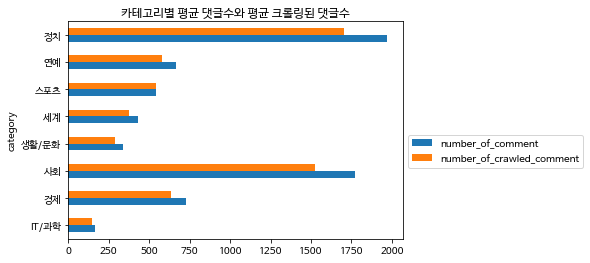

In [752]:
f = plt.figure(figsize=(6,4))
plt.title('카테고리별 평균 댓글수와 평균 크롤링된 댓글수', color='black')
group_by_category.mean().plot.barh( ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [754]:
fDf = df_naver[['category','number_of_comment', 'number_of_crawled_comment']]

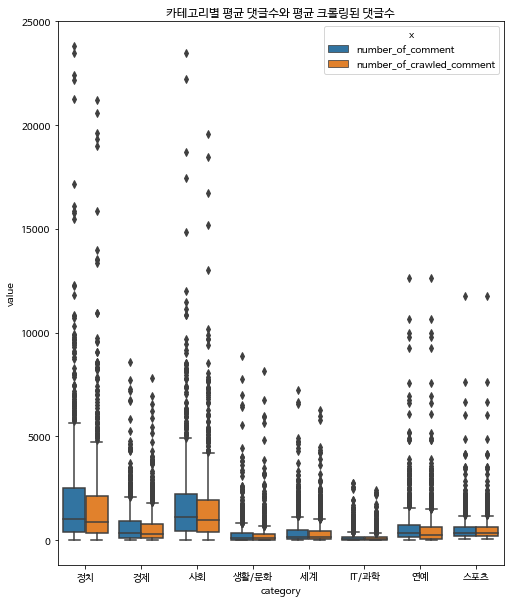

In [755]:
f = plt.figure(figsize=(8,10))
plt.title('카테고리별 평균 댓글수와 평균 크롤링된 댓글수', color='black')
dd = pd.melt(fDf, id_vars = ['category'], value_vars=['number_of_comment', 'number_of_crawled_comment'],var_name='x')
sns.boxplot(x = 'category', y = 'value', data =dd, hue = 'x', ax=f.gca())
plt.show()